<a href="https://colab.research.google.com/github/olegsem79/Yolo/blob/main/29_%D0%94%D0%97_Ligth_IMAGE_Yolo11_test%2Bcount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пайплайн Yolo 11

In [ ]:
# проверяем данной командой, что в среде доступна видеокарта
!nvidia-smi

Thu Sep 25 13:21:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             33W /   70W |    1106MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q ultralytics
!pip install -q supervision
!pip install -q moviepy
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 837.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
# --- Пути ---
SOURCE_IMAGE_PATH = f"{HOME}/29_street_image_6.jpg"

In [11]:
# QWEEN CODER

from ultralytics import YOLO
import supervision as sv
import cv2
import torch
from tqdm import tqdm
import moviepy.editor as mp
import matplotlib.pyplot as plt

In [77]:

# --- Инициализация модели ---
#v8
#model = YOLO("yolov8n.pt") # ms 200 count 19
#model = YOLO("yolov8s.pt") # ms 480 count 27
#model = YOLO("yolov8m.pt") # ms 1000 count 31 +++
#model = YOLO("yolov8l.pt") # ms 1900 count 27
#model = YOLO("yolov8x.pt") # ms 2800 count 30

#v11
model = YOLO('yolo11n.pt') # ms 210 count 18
#model = YOLO('yolo11s.pt') # ms 370 count 26
#model = YOLO('yolo11m.pt') # ms 900 count 25
#model = YOLO('yolo11l.pt') # ms 1200 count 21
#model = YOLO('yolo11x.pt') # ms 2500 count 26

device = 'cuda' if torch.cuda.is_available() else 'cpu'
_ = model.to(device)

print("")
print(f"Модель загружена на: {device}")
print("")

# Установка нужных классов
#model.set_classes(["person", "car"])




Модель загружена на: cpu



In [82]:
#from ultralytics import YOLO
#model = YOLO("yolov8n.pt")
'''
# Для фильтрации по классам
CLASSES = ["person", "car"]
class_names = model.model.names
selected_class_ids = [
    class_id for class_id, name in class_names.items()
    if name in CLASSES
]
'''
# Вывести все классы (ID -> имя)
print(f"Модель знает {len(model.names)} классов")
'''
print("Все классы модели:")
for class_id, class_name in model.model.names.items():
    print(f"{class_id}: {class_name}")
'''

Модель знает 80 классов


'\nprint("Все классы модели:")\nfor class_id, class_name in model.model.names.items():\n    print(f"{class_id}: {class_name}")\n'

In [15]:
# определим аннотатор изображений из supervision
#color_palette = sv.ColorPalette.from_hex(['#ff0000', '#0000ff', '#00ff00', '#ff00ff', '#00ffff', '#ffa500']) # паллета цветов из supervision для аннотации объектов
#box_annotator = sv.BoxAnnotator(color=color_palette)
box_annotator = sv.BoxAnnotator(
    #color=color_palette,
    thickness=2 # толщина бокса = 1
)
#label_annotator = sv.LabelAnnotator(color=color_palette)
#label_annotator = sv.LabelAnnotator()
label_annotator = sv.LabelAnnotator(
    #color=color_palette,
    text_scale=0.5,          # ✅ Уменьшили размер шрифта (по умолчанию 0.5)
    text_thickness=1,        # Толщина текста
    text_padding=5,          # ✅ Уменьшили отступ
    text_color=sv.Color.WHITE  # Цвет текста
)


image 1/1 /content/29_street_image_6.jpg: 448x640 12 persons, 3 bicycles, 4 cars, 1 bus, 2 traffic lights, 1 bench, 1 backpack, 2 handbags, 2403.8ms
Speed: 3.0ms preprocess, 2403.8ms inference, 5.4ms postprocess per image at shape (1, 3, 448, 640)

⏰ Обработка заняла: 2.44 секунд (0.04 минут)
Найдено объектов: 26



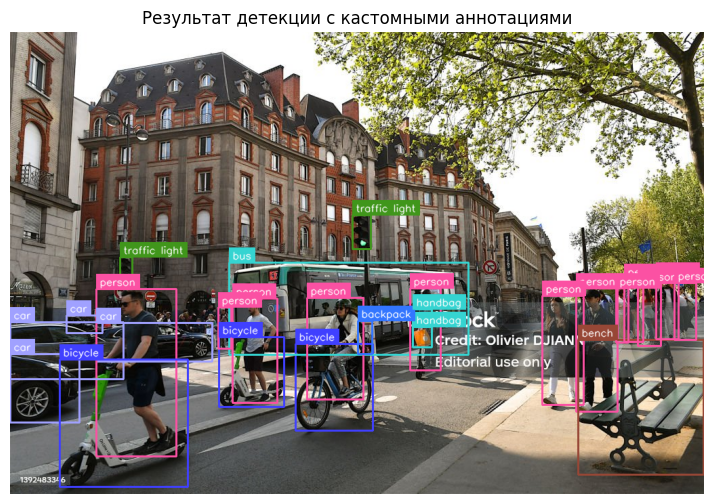


Модель загружена на: cpu

Распределение по классам:
  car: 4 шт.
  bicycle: 3 шт.
  bus: 1 шт.
  person: 12 шт.
  bench: 1 шт.
  traffic light: 2 шт.
  handbag: 2 шт.
  backpack: 1 шт.


In [87]:
import time
from collections import Counter

# узнать время обработки ячейки
start_time = time.time()

results = model.predict(SOURCE_IMAGE_PATH)

end_time = time.time()
elapsed_time = end_time - start_time
print("")
print(f"⏰ Обработка заняла: {elapsed_time:.2f} секунд ({elapsed_time / 60:.2f} минут)")
print(f"Найдено объектов: {len(results[0].boxes)}")
print("")

# Преобразуем результаты в формат Supervision
detections = sv.Detections.from_ultralytics(results[0])

# Загружаем оригинальное изображение
original_image = cv2.imread(SOURCE_IMAGE_PATH)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # BGR to RGB

# Создание копии изображения
annotated_frame = original_image.copy()

#Аннотация bounding box'ов
annotated_frame = box_annotator.annotate(annotated_frame, detections)

#Аннотация подписей
annotated_frame = label_annotator.annotate(annotated_frame, detections)

# Сохраняем результат
#cv2.imwrite('output_image_custom.jpg', cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))

# Показываем с красивостями
plt.figure(figsize=(10, 6))
plt.imshow(annotated_frame)
plt.axis('off')
plt.title('Результат детекции с кастомными аннотациями')
plt.show()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
_ = model.to(device)

print("")
print(f"Модель загружена на: {device}")
print("")

# Подсчет объектов по классам
class_counts = Counter()
for box in results[0].boxes:
    class_id = int(box.cls)  # ID класса
    class_name = model.names[class_id]  # Название класса
    class_counts[class_name] += 1



# Вывод распределения по классам

print("Распределение по классам:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} шт.")

#print("")
#results[0].show()



image 1/1 /content/29_street_image_6.jpg: 448x640 12 persons, 3 bicycles, 4 cars, 1 bus, 2 traffic lights, 1 bench, 1 backpack, 2 handbags, 2592.1ms
Speed: 4.4ms preprocess, 2592.1ms inference, 5.7ms postprocess per image at shape (1, 3, 448, 640)
Модель на: cpu
Объектов: 26

Классы: {'car': 4, 'bicycle': 3, 'bus': 1, 'person': 12, 'bench': 1, 'traffic light': 2, 'handbag': 2, 'backpack': 1}



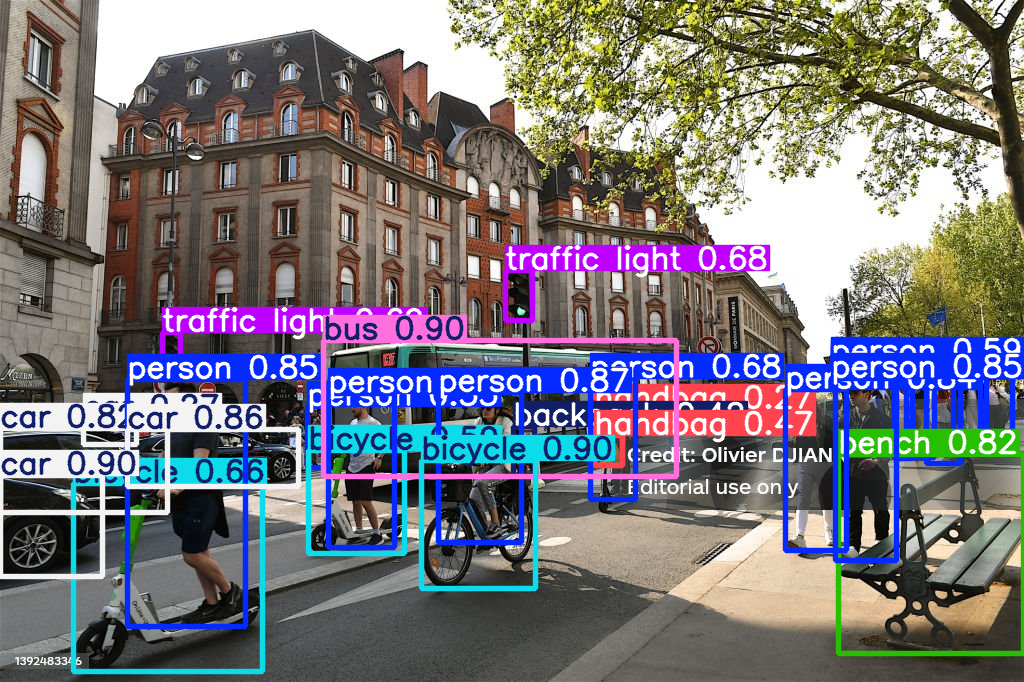

CPU times: user 2.59 s, sys: 132 ms, total: 2.72 s
Wall time: 2.79 s


In [83]:
%%time

results = model.predict(SOURCE_IMAGE_PATH)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
_ = model.to(device)

print(f"Модель на: {device}")
print(f"Объектов: {len(results[0].boxes)}")

# Простой подсчет в одну строку
from collections import Counter
counts = Counter(model.names[int(box.cls)] for box in results[0].boxes)
print("")
print("Классы:", dict(counts))
print("")

results[0].show()